# fig7_slp
SALLJ composites of sea-level pressure (shading) and 500-hPa height contours


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units


In [2]:
# Set up paths
home = Path.home()                 # users home directory
root = home/'repos'/'montini-phd'    # project root directory
path_to_data = root/'data'           # data directory (input data, read only)
path_to_out = root/'out'             # directory for storing numerical results and intermediate datafiles (read & write
path_to_figs = root/'figs'           # directory for storing figures


In [3]:
# Path to modules directory
path_to_mods = os.fspath(root/'modules')
sys.path.append(path_to_mods)

# Import my modules
from plotter import draw_basemap


In [4]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### SALLJ days

In [5]:
filepath = path_to_out / 'sallj-types-ndjfm.csv'
df = pd.read_csv(filepath)


### ERA5 renalysis

In [6]:
# Load SLP data into a new dataset
f1 = xr.open_dataset(path_to_data/'era5.slp.spac.50dg.day.1979-2016.nc')
f2 = xr.open_dataset(path_to_data/'era5.zg.500.spac.50dg.day.1979-2016.nc')

era = xr.merge([f1,f2])

In [ ]:
# load 700 hpa data (sizes don't match.. sep array..)

# era700 = xr.open_dataset(path_to_data/'era5.zg.700.spac.50dg.day.1979-2016.nc')
# #print(era700)

# # Trim date range
# start_date = '1979-11-01'
# end_date = '2016-03-31'
# idx = slice(start_date, end_date)
# era700 = era700.sel(time=idx)

# # Select NDJFM months
# idx = (era700.time.dt.month >= 11) | (era700.time.dt.month <= 3)
# era700 = era700.sel(time=idx)
# #print(era, '\n')

# # Add llj time series to the ERA dataset
# era700['llj'] = ('time', df.LLJ_CAT)
# era700 = era700.set_coords('llj')

# # Select only LLJ days
# idx = (era700.llj >= 1)
# era700_llj = era700.sel(time=idx)

# era700_llj_comp = era700_llj.groupby('llj').mean('time')
# print(era700_llj_comp)


In [7]:
# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)
print(era, '\n')

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 5597)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-11-01T09:00:00 ... 2016-03-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-11-01 ... 2016-03-31T18:00:00
    slp        (time, latitude, longitude) float32 ...
    zg         (time, latitude, longitude) float32 ... 



In [8]:
# Combine SALLJ data w/ reanalysis data

# Add llj time series to the ERA dataset
era['llj'] = ('time', df.LLJ_CAT)
era = era.set_coords('llj')

# Select only LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)
#print(era_llj)


### Composites of SALLJ types

In [9]:
# Compute composites of each SALLJ type
era_llj_comp = era_llj.groupby('llj').mean('time')
print(era_llj_comp)


<xarray.Dataset>
Dimensions:    (latitude: 161, llj: 4, longitude: 307)
Coordinates:
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * llj        (llj) int64 1 2 3 4
Data variables:
    slp        (llj, latitude, longitude) float32 101517.984 ... 98818.97
    zg         (llj, latitude, longitude) float32 5842.0156 ... 5167.2495


## Figure 6

In [10]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=13,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                fontweight='extra bold',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n \n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=8, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='center', 
                transform=transform, zorder=10)

### Data for plotting

In [12]:
# lat/lon arrays
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values

# SLP
slp = era_llj_comp.slp.values / 100.    # 984, 1024

# 500-hPa Heights
hgts_500 = era_llj_comp.zg.values
print(hgts_500.min(),hgts_500.max())

# Smooth contour lines
#thickness_sm = gaussian_filter(thick[k,:,:], sigma=3) / 10.
#slp_smooth = gaussian_filter(slp, sigma=1)
#print(slp_smooth.max(),slp_smooth.min())
#print(slp.max(), slp.min())


5145.108 5877.144


### Set plot parameters

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Projection/Coordinate systems
datacrs = ccrs.PlateCarree()     # data/source
mapcrs = ccrs.PlateCarree()      # map/destination

# Map Boundaries
lonmin = -120
lonmax = -12
latmin = -55 #-60
latmax = 15 #20

# Tickmark/Gridline Locations
dx = np.arange(-90,lonmax,30)
dy = np.arange(-30,latmax,30)

# Labels
plt_labels = ['SALLJ Type 1', 'SALLJ Type 2', 'SALLJ Type 3','SALLJ Type 4']

# 2d lons/lats (for finding min/max points on map)
lons2d, lats2d = np.meshgrid(lons, lats)


### SLP Figure

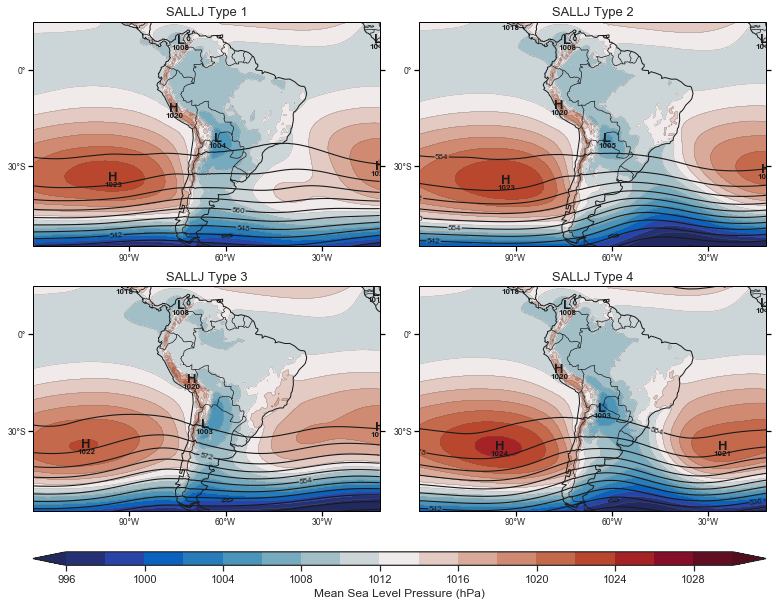

In [15]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# slp
#clevs_slp = np.arange(996,1038+1,2)
cmap= cmo.balance
cmap_slp = cmocean.tools.crop_by_percent(cmap, 7, which='both', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    
    # basemap
   # ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    # xticks
    ax.set_xticks(dx, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(dy, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black', right=True)    
    
    # Plot MSLP
    clevs_slp = np.arange(996,1030+1,2)
    cf = ax.contourf(lons, lats, slp[k,:,:], transform=datacrs,
                     levels=clevs_slp, cmap=cmap_slp, extend='both')
    cfl = ax.contour(lons, lats, slp[k,:,:], transform=datacrs, levels=clevs_slp, 
                     colors='0.37', linewidths=0.3, alpha=0.8)
                    # colors='0.37', linewidths=0.5)
    
    # 500-hPa height lines
    clevs_hgts = np.arange(5000, 6060, 60)
    cl = ax.contour(lons, lats, hgts_500[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts/10, linewidths=1.1,colors='k')# colors='#00009e')
    plt.clabel(cl, fmt='%d', fontsize=8, inline=True, inline_spacing=10, 
               rightside_up=True, use_clabeltext=True) 

     # Add H/L symbols
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'max', 50, 
                       symbol='H', color='k', transform=datacrs)
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'min', 50, 
                       symbol='L', color='k', transform=datacrs) 
        
    # Subtitles 
    ax.set_title(plt_labels[k], loc='center',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', extend='both')
cb.set_label('Mean Sea Level Pressure (hPa)')

# Save figure
filepath = home/'Desktop'/'slp-3.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


### 500-hPa Heights Figure

In [ ]:
#### VERSION 2 - 500 heights (shading) + SLP contours

 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# cmaps
cmap= cmo.phase
cmap_hgts = cmocean.tools.crop_by_percent(cmap, 8, which='both', N=None)
cmap_hgts2 = cmocean.tools.crop_by_percent(cmap, 12, which='max', N=None)


# Loop for drawing each plot
for k, ax in enumerate(axgr):
    
    # basemap
   # ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    # xticks
    ax.set_xticks(dx, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(dy, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black', right=True)    
           
    # 500-hPa height lines
    clevs_hgts = np.arange(5260, 5960, 60)
    cf = ax.contourf(lons, lats, hgts_500[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts/10, cmap=cmap_hgts2, extend='both')
    clevs_hgts = np.arange(5260, 5960, 60)
    cfl = ax.contour(lons, lats, hgts_500[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts/10, colors='k', linewidths=1.0, zorder=10)
    
    # Plot MSLP
#     clevs_slp = np.arange(980,1038+1,4)
#     slp_smooth = gaussian_filter(slp[k,:,:], sigma=0.5)
#     cl = ax.contour(lons, lats, slp[k,:,:], transform=datacrs, levels=clevs_slp, 
#                      colors='w', linewidths=1.4)

     # Add H/L symbols
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'max', 50, 
                       symbol='H', color='k', transform=datacrs)
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'min', 50, 
                       symbol='L', color='k', transform=datacrs) 
        
    # Subtitles 
    ax.set_title(plt_labels[k], loc='center',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', extend='both')
cb.set_label('500-hPa Geopotential Height')

# Save figure
filepath = home/'Desktop'/'geop500-60-2.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()



### 700-hPa heights fig

In [ ]:
# lat/lon arrays
lats = era700_llj_comp.latitude.values
lons = era700_llj_comp.longitude.values
hgts_700 = era700_llj_comp.zg.values
print(hgts_700.min(), hgts_700.max())

In [ ]:
#### VERSION 2 - 500 heights (shading) + SLP contours

 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# cmaps
cmap= cmo.phase
cmap_hgts = cmocean.tools.crop_by_percent(cmap, 8, which='both', N=None)
cmap_hgts2 = cmocean.tools.crop_by_percent(cmap, 12, which='max', N=None)


# Loop for drawing each plot
for k, ax in enumerate(axgr):
    
    # basemap
   # ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax.set_extent([lonmin,lonmax,-53,latmax], crs=mapcrs)
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    # xticks
    ax.set_xticks(dx, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(dy, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black', right=True)    
           
    # 700-hPa height lines
    clevs_hgts = np.arange(272,318,2)
    cf = ax.contourf(lons, lats, hgts_700[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, cmap='plasma', extend='both')
    cfl = ax.contour(lons, lats, hgts_700[k,:,:]/10., transform=datacrs,
                     levels=clevs_hgts, colors='k', linewidths=0.75, zorder=10)
    plt.clabel(cfl, fmt='%d', fontsize=8, inline=True, inline_spacing=10, 
               rightside_up=True, use_clabeltext=True)  

    # Subtitles 
    ax.set_title(plt_labels[k], loc='center',fontsize=13)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', extend='both')
cb.set_label('500-hPa Geopotential Height')

# Save figure
filepath = home/'Desktop'/'geop700.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()